## Potential Talents - Part 4

----

# Job Title Similarity using LLMs-as-Rankers

### Objective
Given a query, ask a small LLM to score **all 104 job titles at once** (0–100, one score per line, same order), then rank the scores to compare the **top-10** with other results (from embeddings + cosine or other LLMs results)

### Constraints
- Local GPU: **GTX 1080 Ti**.
- **Deterministic** generation: `do_sample=False`, `num_beams=1`.

### Models (initial)
- **1:** `microsoft/phi-3-mini-4k-instruct` (4k context, small & GPU-friendly).
- **2:** `google/gemma-2-2b-it` (8k context, very small).
- **3:** `qwen2.5-3B-instruct` (32k context, ~3B params, list-style outputs).
- **4:** `moonshot/kimi-K2-(K2-0711)`
- **5:** `meta/llama-3.2-3B-Instruct`
- **6:** `deepseek/deepseek-v3.1-chat`
- **7:** ``
- **8:** `openai/chatgpt-4o`
- (After some tests we will avoid FLAN-T5 here due to the ~512 token input limit.)

### Method
1) Load SBERT top-10 baseline (from Part 3).  
2) Load a small **causal LM**.  
3) Build a prompt that lists all **104** titles (numbered).  
4) Generate **104 lines of integers**; parse → rank; print top-10; save top-10 CSV (`query,score,job_titles`).  
5) Repeat for the 4 queries; later compute nDCG@10 and compare.



----


### Step 0 - Imports, config, folders

In [3]:
# core
import os, json, math, re, random, time, sys
import numpy as np
import pandas as pd

# HF
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline

In [4]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# paths
DATA_DIR = "data"
OUT_DIR  = "outputs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

QUERIES = ["data scientist", "machine learning engineer", "backend developer", "product manager"]  # same queries from Part 3

### Step 1 - Load titles and make a clean field

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, "potential_talents.csv"))

In [6]:
titles = df["job_title"].astype(str).tolist()
len(titles), titles[:5]

(104,
 ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  'Native English Teacher at EPIK (English Program in Korea)',
  'Aspiring Human Resources Professional',
  'People Development Coordinator at Ryan',
  'Advisory Board Member at Celal Bayar University'])

### Step 2 - Load SBERT top-10 baseline (as-is, from the previous project part 3)

In [7]:
# Load your SBERT baseline as produced in Part 3 (no changes to schema)
BASELINE_TOP10_CSV = os.path.join(OUT_DIR, "sbert_ranking_output.csv")
base = pd.read_csv(BASELINE_TOP10_CSV)

print(base.head(3))
print("Queries in baseline:", base["query"].unique())

            query     score                                         job_titles
0  data scientist  0.595830  Information Systems Specialist and Programmer ...
1  data scientist  0.494619                       Human Resources Professional
2  data scientist  0.456588           Junior MES Engineer| Information Systems
Queries in baseline: ['data scientist' 'machine learning engineer' 'backend developer'
 'product manager']


### Step 3 - Pretty printer (same style as Part 3)

In [8]:
def print_ranking(query, rows_df, score_col="score", title_col="job_titles", top_k=10):
    print(f"\nQuery: {query}")
    for _, r in rows_df.head(top_k).iterrows():
        print(f"   {r[score_col]: .3f}  {r[title_col]}")


In [9]:
for query in QUERIES:
    print_ranking(query, base)


Query: data scientist
    0.596  Information Systems Specialist and Programmer with a love for data and organization.
    0.495  Human Resources Professional
    0.457  Junior MES Engineer| Information Systems
    0.450  Aspiring Human Resources Specialist
    0.449  Human Resources professional for the world leader in GIS software
    0.441  HR Senior Specialist
    0.433  Human Resources Generalist at ScottMadden, Inc.
    0.416  Liberal Arts Major. Aspiring Human Resources Analyst.
    0.410  Student
    0.403  Human Resources Specialist at Luxottica

Query: machine learning engineer
    0.596  Information Systems Specialist and Programmer with a love for data and organization.
    0.495  Human Resources Professional
    0.457  Junior MES Engineer| Information Systems
    0.450  Aspiring Human Resources Specialist
    0.449  Human Resources professional for the world leader in GIS software
    0.441  HR Senior Specialist
    0.433  Human Resources Generalist at ScottMadden, Inc.
  

### Step 4 - Experience with <img src="./sup_imgs/phi-3-mini.png" width="225" style="vertical-align: middle;"/>

**Phi-3 Mini**
- **Release Date**: April 23, 2024.
- **Architecture**: Decoder-only (autoregressive).
- **Parameters**: ~3.8B.
- **Layers**: 32 transformer blocks, 32 attention heads.
- **Context Window**: 4k tokens.
- **Tokenizer**: SentencePiece-like (subword BPE).
- **Objective**: Next-token prediction, trained as a general causal LM.
- **Training**: Mixture of web, code, math, scientific texts; instruction-tuned for dialogue.
- **Efficiency**: Optimized for small GPUs (runs on 8–12GB VRAM), strong FP16/INT8 support.
- **License**: MIT-style permissive.
- **Notes**: Very lightweight, deterministic, good for structured tasks on consumer GPUs.

In [10]:
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [11]:
MODEL_ID = "microsoft/phi-3-mini-4k-instruct"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.float16 if torch.cuda.is_available() else None,
).to("cuda" if torch.cuda.is_available() else "cpu").eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
# Build a proper chat prompt
msgs = [
    {"role": "system", "content": "You are a calculator. Reply with digits only."},
    {"role": "user",   "content": "Return the number 7."}
]
prompt = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)


In [13]:
# Encode & generate (greedy)
inputs = tok(prompt, return_tensors="pt").to(mdl.device)
eos = [tok.eos_token_id]
try:
    eos.append(tok.convert_tokens_to_ids("<|end|>"))
except Exception:
    pass

In [14]:
gen = mdl.generate(
    **inputs,
    do_sample=False,
    num_beams=1,
    max_new_tokens=3,
    eos_token_id=eos,
)


In [15]:
out = tok.decode(gen[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
print(out)  # -> 7

7


### Step 5 — turn LLM into a job title ranker

We will turn the LLM into a ranker by asking it to assign an integer score (0–100) to each raw job title for a given query.


In [16]:
def build_prompt_all_chat_phi(query: str, titles: list[str]) -> str:
    lines = "\n".join(f"{i+1}) {t}" for i, t in enumerate(titles))
    rubric = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Rate each candidate with an integer 0–100 using the FULL scale:\n"
        " • 90–100 = exact/near-exact role match\n"
        " • 70–89  = same discipline or very similar role\n"
        " • 40–69  = related/adjacent\n"
        " • 10–39  = mostly unrelated\n"
        " • 0–9    = completely unrelated\n"
        "Use diverse scores; do NOT give 0 or 100 to many candidates.\n"
        "Ignore employer names, locations, programs.\n"
        "Output EXACTLY one integer per line, in the SAME ORDER as the candidates. No words, no punctuation."
    )
    # Non-extreme example
    example = "Example for 3 candidates:\n82\n41\n7"
    user = f'Query: "{query}"\n\nCandidates:\n{lines}\n\n{example}'
    msgs = [{"role": "system", "content": rubric},
            {"role": "user",   "content": user}]
    return tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    


In [17]:
def parse_scores_n(out: str, n: int) -> list[int]:
    # prefer last int per non-empty line; fallback to last N ints in whole text
    lines = [l.strip() for l in out.splitlines() if l.strip()]
    scores = []
    
    for line in lines:
        ints = re.findall(r"-?\d+", line)
        if ints:
            scores.append(int(ints[-1]))
        if len(scores) >= n:
            break
        
    if len(scores) < n:
        all_ints = [int(x) for x in re.findall(r"-?\d+", out)]
        scores = all_ints[-n:]
        
    scores = [max(0, min(100, int(s))) for s in scores]
    
    # if still short, add a padding
    if len(scores) < n:  
        scores += [0] * (n - len(scores))
    return scores[:n]

In [18]:
def score_all_titles_once(query: str,
                          titles: list[str],
                          max_new_tokens: int = 300,
                          build_fn=None):
    build_fn = build_fn or build_prompt_all_chat_phi
    prompt = build_fn(query, titles)
    print("Prompt tokens:", len(tok(prompt)["input_ids"]))
    inputs = tok(prompt, return_tensors="pt").to(mdl.device)
    gen = mdl.generate(
        **inputs,
        do_sample=False,
        num_beams=1,
        max_new_tokens=max_new_tokens,
        eos_token_id=[tok.eos_token_id],
        min_new_tokens=min(len(titles), max_new_tokens-1),
    )
    out_text = tok.decode(gen[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    scores = parse_scores_n(out_text, len(titles))
    df = pd.DataFrame({"idx": range(len(titles)), "score": scores})
    df["job_titles"] = [titles[i] for i in df["idx"]]
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    return df, out_text



Test **build_prompt_all_chat**, **parse_scores_n** and **score_all_tittles_once**

In [19]:
test_query = "data scientist"

# A Tiny subset to inspect everything
subset = titles[:5]

demo_prompt = build_prompt_all_chat_phi(test_query, subset)
print("=== DEMO PROMPT (first 30 lines) ===")
print("\n".join(demo_prompt.splitlines()[:30]))
print("Token count (subset):", len(tok(demo_prompt)["input_ids"]))


=== DEMO PROMPT (first 30 lines) ===
<|system|>
You are a recruiter scoring job-title similarity to the query.
Rate each candidate with an integer 0–100 using the FULL scale:
 • 90–100 = exact/near-exact role match
 • 70–89  = same discipline or very similar role
 • 40–69  = related/adjacent
 • 10–39  = mostly unrelated
 • 0–9    = completely unrelated
Use diverse scores; do NOT give 0 or 100 to many candidates.
Ignore employer names, locations, programs.
Output EXACTLY one integer per line, in the SAME ORDER as the candidates. No words, no punctuation.<|end|>
<|user|>
Query: "data scientist"

Candidates:
1) 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2) Native English Teacher at EPIK (English Program in Korea)
3) Aspiring Human Resources Professional
4) People Development Coordinator at Ryan
5) Advisory Board Member at Celal Bayar University

Example for 3 candidates:
82
41
7<|end|>
<|assistant|>
Token count (subset): 279


In [20]:
df_sub, raw_sub = score_all_titles_once(test_query, subset, max_new_tokens=60)
print("\n=== RAW MODEL OUTPUT (subset) ===")
print(raw_sub)

Prompt tokens: 279

=== RAW MODEL OUTPUT (subset) ===
0
0
7
41
0


In [21]:
scores_sub = parse_scores_n(raw_sub, len(subset))
print("\nParsed scores (subset):", scores_sub)
print("\nPaired (score, title) in ranked order:")
# the output DataFrame from `socre_all_titles_once`, df_sub, is sorted in not ascending order
for _, r in df_sub.iterrows():
    print(f"{r['score']:>3}  {r['job_titles']}")


Parsed scores (subset): [0, 0, 7, 41, 0]

Paired (score, title) in ranked order:
 41  People Development Coordinator at Ryan
  7  Aspiring Human Resources Professional
  0  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
  0  Native English Teacher at EPIK (English Program in Korea)
  0  Advisory Board Member at Celal Bayar University


In [22]:
# B) One full run (preview only; avoids flooding output)
full_prompt = build_prompt_all_chat_phi(test_query, titles)
print("\nToken count (full):", len(tok(full_prompt)["input_ids"]))


Token count (full): 1928


In [23]:
# truncation of long strings
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 200)


In [24]:
df_full, raw_full = score_all_titles_once(test_query, titles, max_new_tokens=300)
print("\nFull run: got", len(df_full), "scores.")
print("Top-3 preview:")
print(df_full.head(10)[["score", "job_titles"]])

Prompt tokens: 1928

Full run: got 104 scores.
Top-3 preview:
   score                                                                                                job_titles
0    100                                         Student at Humber College and Aspiring Human Resources Generalist
1    100                                                           Advisory Board Member at Celal Bayar University
2    100                                                                     Aspiring Human Resources Professional
3     90                                                                       Aspiring Human Resources Specialist
4     89                                         Student at Humber College and Aspiring Human Resources Generalist
5     74                                                                     Aspiring Human Resources Professional
6     72                                                 Native English Teacher at EPIK (English Program in Korea)
7     70  2019 C.T

In [25]:
def print_ranking(query, rows_df, top_k=10):
    print(f"\nQuery: {query}")
    for _, r in rows_df.head(top_k).iterrows():
        print(f"   {r['score']/100: .3f}  {r['job_titles']}")

def run_query_full(queries: list[str],
                   model_tag: str = "phi3_mini_4k",
                   build_prompt_fn=None):
    out_dir = os.path.join(OUT_DIR, "llm"); os.makedirs(out_dir, exist_ok=True)
    top10_blocks = []
    for query in queries:
        df_rank, raw = score_all_titles_once(query, titles, build_fn=build_prompt_fn)
        print_ranking(query, df_rank, top_k=10)
        df_q = df_rank.head(10)[["score", "job_titles"]].copy()
        df_q.insert(0, "query", query)
        top10_blocks.append(df_q)
    top10 = pd.concat(top10_blocks, ignore_index=True)
    path = os.path.join(out_dir, f"llm_top10__{model_tag}__all_queries.csv")
    top10.to_csv(path, index=False)
    print("Saved:", path)
    return top10, path

In [26]:
top10_phi, path_phi = run_query_full(
    QUERIES,
    model_tag="phi3_mini_4k__listwise",
    build_prompt_fn=build_prompt_all_chat_phi
)


Prompt tokens: 1928

Query: data scientist
    1.000  Student at Humber College and Aspiring Human Resources Generalist
    1.000  Advisory Board Member at Celal Bayar University
    1.000  Aspiring Human Resources Professional
    0.900  Aspiring Human Resources Specialist
    0.890  Student at Humber College and Aspiring Human Resources Generalist
    0.740  Aspiring Human Resources Professional
    0.720  Native English Teacher at EPIK (English Program in Korea)
    0.700  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.700  HR Senior Specialist
    0.690  Student at Chapman University
Prompt tokens: 1928

Query: machine learning engineer
    1.000  Student at Humber College and Aspiring Human Resources Generalist
    1.000  Advisory Board Member at Celal Bayar University
    1.000  Aspiring Human Resources Professional
    0.900  Aspiring Human Resources Specialist
    0.890  Student at Humber College and Aspiring Human

----

### Step 6 - Experience with Gemma-2-2b-it   <img src="./sup_imgs/gemma2.webp" width="225" style="vertical-align: middle;"/>

**Gemma-2-2B-IT (Google)**
- **Release Date**: June 27, 2024 (Gemma 2 family launch).
- **Architecture**: Decoder-only (autoregressive).
- **Parameters**: ~2.6B.
- **Layers**: ~26 transformer layers (with RoPE).
- **Context Window**: 8k tokens.
- **Tokenizer**: SentencePiece (same family as PaLM-2 / Gemini).
- **Objective**: Next-token prediction with instruction-tuning.
- **Training**: Web-scale datasets filtered for quality, multilingual corpora.
- **Efficiency**: Ultra-compact, designed for edge devices; runs well on 6–8GB GPUs.
- **License**: Apache 2.0 (permissive).
- *Notes*: Very small but instruction-tuned, produces stable integer list outputs if well-prompted.

Free the GPU's allocated memory:

In [27]:
import gc

In [28]:
def free_GPU_memory():
    def print_vram(prefix=""):
        if not torch.cuda.is_available():
            print(prefix + "CUDA not available")
            return
        torch.cuda.synchronize()
        alloc = torch.cuda.memory_allocated() / (1024**2)      # MiB
        reserv = torch.cuda.memory_reserved() / (1024**2)      # MiB
        total = torch.cuda.get_device_properties(0).total_memory / (1024**2)
        print(f"\n{prefix}allocated: {alloc:.1f} MiB | reserved: {reserv:.1f} MiB | total: {total:,.0f} MiB")

    # Print memory allocation before freeing it
    print("Measure memory usage before and after freeing it")
    print_vram("Before:\n")

    # move model to CPU + delete big refs
    try: mdl.to("cpu")
    except: pass
    # free memory
    for name in ("pipe","mdl","tok","inputs","gen"):
        if name in globals(): del globals()[name]

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print_vram("After:\n")


In [29]:
free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 7296.5 MiB | reserved: 8596.0 MiB | total: 11,264 MiB

After:
allocated: 8.1 MiB | reserved: 20.0 MiB | total: 11,264 MiB


In [30]:
MODEL_ID = "google/gemma-2-2b-it"
HF_TOKEN = os.getenv("llm_gemma")

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.float16 if device.type=="cuda" else None,
    token=HF_TOKEN
).to(device).eval()

if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

pipe = pipeline("text-generation", model=mdl, tokenizer=tok, device=0 if device.type=="cuda" else -1)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Define a newer **prompt builder** function with a one-shot prompt and being more specific with the matching job titles. Also it drops the `system role` options that we used with Phi-3:

In [31]:

def build_prompt_all_chat_gemma(query: str, titles: list[str]) -> str:
    lines = "\n".join(f"{i+1}) {t}" for i, t in enumerate(titles))
    rubric = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Rate each candidate with an integer between zero and one hundred using the full scale.\n"
        "Use diverse scores; avoid giving many zeros or many hundreds.\n"
        "Ignore employer names, locations, and programs.\n"
        "Return EXACTLY one integer per line in the SAME ORDER as the candidates.\n"
        "No words, no punctuation, no numbering.\n"
    )
    user_text = f'Query: "{query}"\n\nCandidates:\n{lines}\n\nSCORES:'
    # Gemma’s template may not support a system role → fold rubric into the user turn
    msgs = [{"role": "user", "content": rubric + "\n\n" + user_text}]
    return tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)

In [32]:
top10_gemma, path_gemma = run_query_full(
    QUERIES,
    model_tag="gemma-2-2b-it__listwise",
    build_prompt_fn=build_prompt_all_chat_gemma
)

Prompt tokens: 1583

Query: data scientist
    0.200  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.100  Native English Teacher at EPIK (English Program in Korea)
    0.100  Aspiring Human Resources Professional
    0.100  People Development Coordinator at Ryan
    0.100  Advisory Board Member at Celal Bayar University
    0.100  Aspiring Human Resources Specialist
    0.100  Student at Humber College and Aspiring Human Resources Generalist
    0.100  HR Senior Specialist
    0.100  Student at Humber College and Aspiring Human Resources Generalist
    0.100  Seeking Human Resources HRIS and Generalist Positions
Prompt tokens: 1584

Query: machine learning engineer
    0.200  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.100  Native English Teacher at EPIK (English Program in Korea)
    0.100  Aspiring Human Resources Professional
    0.100  People Developmen

----

### Step 7 - Experience with Qwen2.5-3B-Instruct from <img src="./sup_imgs/Qwen_Logo.svg.png" width="175" style="vertical-align: middle;"/>

**Qwen2.5-3B-Instruct (Alibaba / Qwen Team)**
- **Release Date**: September 5, 2024 (Qwen2.5 family release).
- **Architecture**: Decoder-only (autoregressive).
- **Parameters**: ~2.7–3B.
- **Layers**: 28 transformer layers, 32 attention heads.
- **Context Window**: 32k tokens (longest among your three).
- **Tokenizer**: Custom BPE with multilingual coverage.
- **Objective**: Next-token prediction, instruction-tuned with ChatML formatting.
- **Training**: Massive multilingual web + code datasets, plus safety/alignment finetuning.
- **Efficiency**: Larger context needs more VRAM, but still runnable on 12GB with FP16/INT8.
- **License**: Apache 2.0.
- *Notes*: Very strong for structured outputs (list-style, JSON); context length makes it robust for 104-title scoring.

In [33]:
free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 4995.6 MiB | reserved: 5710.0 MiB | total: 11,264 MiB

After:
allocated: 8.1 MiB | reserved: 20.0 MiB | total: 11,264 MiB


In [34]:
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.float16 if torch.cuda.is_available() else None,
).to("cuda" if torch.cuda.is_available() else "cpu").eval()

if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
# Qwen-specific prompt builder (ChatML-friendly, explicit N, hard stop)
def build_prompt_all_chat_qwen(query: str, titles: list[str]) -> str:
    n = len(titles)
    lines = "\n".join(f"{i}) {t}" for i, t in enumerate(titles, start=1))

    rubric = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Score each candidate with an integer 0–100 using the FULL scale:\n"
        "  90–100 = exact/near-exact role match\n"
        "  70–89  = same discipline or very similar role\n"
        "  40–69  = related/adjacent\n"
        "  20–39  = mostly unrelated\n"
        "  0–19   = completely unrelated\n"
        "Rules:\n"
        " - Prefer same functional domain as the query.\n"
        " - If the query is technical (data/ML/backend), HR/People titles are mostly unrelated.\n"
        " - Titles with 'Student' or 'Aspiring' get lower scores unless they explicitly match the role.\n"
        f"Output EXACTLY {n} integers, one per line, in the SAME ORDER as the candidates.\n"
        "No words, no commas, no numbering, no punctuation.\n"
        f"After the {n}th line, output the token <END> and stop."
    )

    # very small one-shot to demonstrate format (3 lines + <END>)
    # keep it generic so it transfers across queries
    example = (
        "Example (3 candidates):\n"
        "Candidates:\n"
        "1) Senior Data Scientist\n"
        "2) HR Coordinator\n"
        "3) Retail Cashier\n"
        "Expected output:\n"
        "95\n"
        "20\n"
        "0\n"
        "<END>"
    )

    user_text = (
        f"{rubric}\n\n"
        f'Query: "{query}"\n\n'
        f"Candidates:\n{lines}\n\n"
        f"{example}"
    )

    # Qwen supports system; if anything fails, fall back to user-only.
    msgs_sys = [
        {"role": "system", "content": "You are precise and output only the requested numbers."},
        {"role": "user",   "content": user_text},
    ]
    msgs_user = [{"role": "user", "content": user_text}]  # fallback

    try:
        return tok.apply_chat_template(msgs_sys, tokenize=False, add_generation_prompt=True)
    except Exception:
        return tok.apply_chat_template(msgs_user, tokenize=False, add_generation_prompt=True)


In [36]:
top10_qwen, path_qwen = run_query_full(
    QUERIES,
    model_tag="qwen2.5-3b-instruct__listwise",
    build_prompt_fn=build_prompt_all_chat_qwen
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prompt tokens: 1774

Query: data scientist
    0.900  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.900  People Development Coordinator at Ryan
    0.900  Student at Humber College and Aspiring Human Resources Generalist
    0.900  People Development Coordinator at Ryan
    0.900  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.900  Native English Teacher at EPIK (English Program in Korea)
    0.900  Human Resources Coordinator at InterContinental Buckhead Atlanta
    0.900  Seeking Human Resources HRIS and Generalist Positions
    0.900  People Development Coordinator at Ryan
    0.900  Student at Humber College and Aspiring Human Resources Generalist
Prompt tokens: 1775

Query: machine learning engineer
    0.900  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.400  People Development Coordinator

----

### Step 8 - Experience with Kimi K2 from <img src="./sup_imgs/moonshot_AI.png" width="175" style="vertical-align: middle;"/>

**Kimi K2 (K2-0711) / Moonshot AI**
- **Release Date**: July 11, 2025.
- **Architecture**: Mixture-of-Experts (MoE) Transformer with MLA (Multi-head Latent Attention)
- **Parameters**: ~1T total, ~32B activated (MoE).
- **Layers**: 61 total (including 1 dense layer); 64 attention heads; 384 experts; 8 selected experts per token; 1 shared expert.
- **Context Window**: 256K tokens (longest among your three).
- **Tokenizer**: Custom tokenizer; covab size 160K.
- **Objective**: Language Modeling (causal/next-token) with multi-stage post-training focused on agentic capabilities (tool use, planning) using RL variants.
- **Training**: Pre-trained on 15.T tokens with the MuonChip optimizer; post-training includes large-scale agentic data synthesis and RLVR + self-critique.
- **Efficiency**: MoE with 32B active params; block-FP8 checkpointsl recommended engines include vLLM, SGLang, KTransformers, TensorRT-LLM
- **License**: Modified MIT (code and weights)
- *Notes*: OpenAI/Anthropic-compatible API available via platform.moonshot.ai; recommended temperature ~ 0.6 for Instruct variants; strong tool-calling support.

In [37]:
free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 6002.6 MiB | reserved: 6798.0 MiB | total: 11,264 MiB

After:
allocated: 8.1 MiB | reserved: 20.0 MiB | total: 11,264 MiB


In [38]:
from openai import OpenAI
from typing import List, Tuple
from dotenv import load_dotenv

For this model we will use the **MOONSHOT API**. Therefor, we will read the API KEY from the .env file

In [39]:
load_dotenv()
api_key = os.getenv("MOONSHOT_API_KEY")
base_url = os.getenv("MOONSHOT_API_BASE", "https://api.moonshot.ai/v1")
if not api_key:
    raise RuntimeError("MOONSHOT_API_KEY is not set. Check your .env or environment.")

client = OpenAI(api_key=api_key, base_url=base_url)

In [40]:
# Choose model (check Moonshot platform for latest stable/previews)
KIMI_MODEL_ID = os.getenv("KIMI_MODEL_ID", "kimi-k2-0905-preview")

##### Here we add a thin **Kimi (Moonshot)** adapter so the evaluation pipeline stays identical to previous local HF models: same rubric/prompt format, same strict parser (`parse_scores_n` → exactly **N** integers 0–100), same **ranking/CSV artifacts**, and **temperature=0** for determinism. 

##### The only change is the generation call (OpenAI-compatible Chat Completions API) wrapped by `score_all_titles_once_kimi` and `run_query_full_kimi`. This preserves apples-to-apples comparisons against Reference-A (ChatGPT-5) while letting swap models with just the prompt builder and the scorer entry point.

In [41]:
# Kimi prompt builder (simple, parser-friendly, same rubric)
def build_scoring_prompt_kimi(query: str, candidates: list[str]) -> str:
    n = len(candidates)
    header = (
        "You are a recruiter scoring job-title similarity to the query\n"
        "Rate each candidate with an integer 0–100 using the FULL scale:\n"
        "• 90–100 = exact/near-exact role match\n"
        "• 70–89  = same discipline or very similar role\n"
        "• 40–69  = related/adjacent\n"
        "• 10–39  = mostly unrelated\n"
        "• 0–9    = completely unrelated\n"
        "Use diverse scores; do NOT give 0 or 100 to many candidates.\n"
        "Ignore employer names, locations, programs.\n"
        f"Output EXACTLY {n} integers, one per line, in the SAME ORDER as the candidates.\n"
        "Integers ONLY (no decimals, no percentages, no words, no punctuation).\n\n"
        "Example for 3 candidates:\n82\n41\n7\n"
        "---\n"
    )
    return header + f'Query: "{query}"\nCandidates:\n' + "\n".join(candidates)

In [42]:
# Kimi scorer (adapter with same return shape as your local scorer)
def score_all_titles_once_kimi(query: str,
                               titles: list[str],
                               max_new_tokens: int = 1200,
                               build_fn=build_scoring_prompt_kimi):
    prompt = build_fn(query, titles)
    resp = client.chat.completions.create(
        model=KIMI_MODEL_ID,         
        temperature=0.1,
        top_p=1.0,
        frequency_penalty=0.2,
        max_tokens=max_new_tokens,
        messages=[{"role": "user", "content": prompt}],
    )
    # debug code
    # raw = resp.choices[0].message.content or ""
    # lines = [ln for ln in raw.splitlines() if ln.strip()]
    # print("parsed_ints:", sum(ln.strip().isdigit() for ln in lines))
    # print("unique_ints:", len({int(ln.strip()) for ln in lines if ln.strip().isdigit()}))

    out_text = resp.choices[0].message.content or ""
    scores = parse_scores_n(out_text, len(titles))   # reuse the original parser
    df = pd.DataFrame({"idx": range(len(titles)), "score": scores})
    df["job_titles"] = [titles[i] for i in df["idx"]]
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    return df, out_text

In [43]:
# Wrapper runner mirroring the run_query_full original function
def run_query_full_kimi(queries: list[str],
                        model_tag: str = "kimi-k2-0905",
                        build_prompt_fn=build_scoring_prompt_kimi):
    out_dir = os.path.join(OUT_DIR, "llm"); os.makedirs(out_dir, exist_ok=True)
    top10_blocks = []
    for query in queries:
        df_rank, raw = score_all_titles_once_kimi(query, titles, build_fn=build_prompt_fn)
        print_ranking(query, df_rank, top_k=10)   # <- reuse pretty-printer
        df_q = df_rank.head(10)[["score", "job_titles"]].copy()
        df_q.insert(0, "query", query)
        top10_blocks.append(df_q)
    top10 = pd.concat(top10_blocks, ignore_index=True)
    path = os.path.join(out_dir, f"llm_top10__{model_tag}__all_queries.csv")
    top10.to_csv(path, index=False)
    print("Saved:", path)
    return top10, path

In [44]:
top10_kimi, path_kimi = run_query_full_kimi(
    QUERIES,
    model_tag="kimi-k2-0905-preview__listwise",
    build_prompt_fn=build_scoring_prompt_kimi
)


Query: data scientist
    0.080  People Development Coordinator at Ryan
    0.070  Aspiring Human Resources Professional
    0.060  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.060  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
    0.060  Seeking Human Resources HRIS and Generalist Positions
    0.060  Native English Teacher at EPIK (English Program in Korea)
    0.060  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.050  Student at Humber College and Aspiring Human Resources Generalist
    0.050  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
    0.050  Student at Humber College and Aspiring Human Resources Generalist

Query: machine learning engineer
    0.090  Retired Army National Guard Recruiter, office manager,  seeking a position 

---

### Step 9 - Experience with <img src="./sup_imgs/LLaMA3.png" alt="DeepSeek Logo" width="175" style="vertical-align: middle;"/>

**LLaMA 3.2 3B Instruct / Meta AI**
- **Release Date**: September 25, 2024.
- **Architecture**: Autoregressive (decoder-only) Transformer with Grouped-Query Attention (GQA) and RoPE  .
- **Parameters**: ~3.21B
- **Layers**: 28 transformer layers, 24 attention heads, 8 KV heads, hidden size 3072 (per model configs) 
- **Context Window**: 128K tokens
- **Tokenizer**: Llama-3 tokenizer (BPE) with 128,256 vocab size (vs. 32K in Llama 2).
- **Objective**: Causal next-token LM; instruction models aligned for dialogue/agentic tasks.
- **Training**: Pretrained on up to ~9T+ tokens; for 1B/3B, destillation from Llama 3.1 8B/70B was used; knowledge cutoff Dec 2023.
- **Efficiency**: Designed for edge/on-device and small-GPU use; keeps the long 128 K context for large candidate lists.
- **License**: Llama 3.2 Community License.
- *Notes*: Use recent Transformers with the official Llama 3.x chat template for best adherence to constrained outputs.

In [45]:
free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 8.1 MiB | reserved: 20.0 MiB | total: 11,264 MiB

After:
allocated: 8.1 MiB | reserved: 20.0 MiB | total: 11,264 MiB


#### **\\!/** Note on running LLaMA locally (Windows, VRAM, and speed)

I first tried `Llama 3.1 8B Instruct` in FP16/BF16 on Windows. With my GPU (~11 GB VRAM), the model didn’t fit, so device_map="auto" offloaded layers to CPU.
Result: **generation became very slow** (one run sat for ~28 minutes) because most of the compute happened on the CPU instead of the GPU.

I also considered 4-bit quantization to fit 8B, but on Windows the **`bitsandbytes`** wheel isn’t reliably available/officially supported. It’s easier on Linux, but I’m avoiding that detour for now.

Decision: switch to **`LLaMA 3 (3.2) 3B Instruct`**, which fits comfortably in ~11 GB and runs on the GPU at normal speed (no offload).

In [46]:
# Model: 3B Instruct (works well on ~11 GB VRAM)
MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

tok = AutoTokenizer.from_pretrained(MODEL_ID, token=os.getenv("HF_TOKEN"), use_fast=True)

mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.bfloat16 if torch.cuda.is_available() else None,  # or torch.float16
    device_map="auto",
    token=os.getenv("HF_TOKEN"),
    #attn_implementation="flash_attention_2",  # let Transformers pick SDPA/eager automatically
).eval()

if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [47]:
# LLaMA prompt builder (same simple rubric + 3-line example)
def build_prompt_all_chat_llama(query: str, titles: list[str]) -> str:
    n = len(titles)
    rubric = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Rate each candidate with an integer 0–100 using the FULL scale:\n"
        "• 90–100 = exact/near-exact • 70–89 = very similar • 40–69 = related\n"
        "• 10–39 = mostly unrelated • 0–9 = unrelated\n"
        f"Output EXACTLY {n} integers, one per line, in the SAME ORDER as the candidates.\n"
        "Integers ONLY (no decimals, no words, no punctuation). Use the full range; avoid identical scores.\n\n"
        f'Query: "{query}"\n'
        "Candidates:\n" + "\n".join(titles)
    )
    messages = [
        {"role": "system", "content": "You are precise and output only the requested integers."},
        {"role": "user", "content": rubric},
    ]
    try:
        return tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        return rubric


#### The rationale for introducing the new pairwise scoring functions:

With small local models (e.g., LLaMA-3.2-3B on ~11 GB VRAM), the original *listwise prompt*,“scoring all 104 titles at once”, is brittle. The model must hold a long rubric plus 100+ candidates and emit exactly 104 integers in order. In practice this led to early stopping, example-echoing, flat/identical scores across queries, and heavy parser padding with zeros.

**The new design scores one title at a time**: one compact prompt per (query, title) returning a single integer (0–100). This drastically lowers the cognitive and formatting burden, so the 3B model gives stable, query-dependent scores with greedy decoding. A simple one-int parser replaces the fragile N-line parser, and the final ranking comes from sorting the 104 individual scores.

To **balance quality vs. cost**, we’ll use a hybrid approach:
• For local small LMs → pairwise (robust, accurate on the available hardware).
• For hosted/strong LMs (DeepSeek R1, ChatGPT-class, Kimi K2, etc.) → **listwise** (one shot per query is cheaper and fast, and these models follow the rubric well).


In [49]:
# Single-candidate prompt (zero-shot, integers only)
def build_prompt_single_llama(query: str, title: str) -> str:
    n = 1
    instr = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Return EXACTLY one integer 0–100.\n"
        "Scale:\n"
        " • 90–100 = exact/near-exact\n"
        " • 70–89  = very similar\n"
        " • 40–69  = related/adjacent\n"
        " • 10–39  = mostly unrelated\n"
        " • 0–9    = unrelated\n"
        "Return the integer ONLY (no words, no punctuation, no decimals)."
    )
    user = f'Query: "{query}"\nCandidate:\n{title}'
    messages = [
        {"role": "system", "content": instr},
        {"role": "user",   "content": user},
    ]
    try:
        return tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        return instr + "\n\n" + user

# Parse exactly one integer
def parse_one_int(text: str) -> int:
    import re
    m = re.findall(r"-?\d+", text)
    if not m: 
        return 0
    x = int(m[-1])
    return max(0, min(100, x))

# Pairwise scorer that preserves your downstream format
def score_titles_llama_pairwise(query: str, all_titles: list[str], max_new_tokens: int = 8):
    rows = []
    for i, title in enumerate(all_titles):
        prompt = build_prompt_single_llama(query, title)
        inputs = tok(prompt, return_tensors="pt").to(mdl.device)
        out_ids = mdl.generate(
            **inputs,
            do_sample=False,
            num_beams=1,
            max_new_tokens=max_new_tokens,
            pad_token_id=tok.eos_token_id,
            use_cache=True,
        )
        out_txt = tok.decode(out_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
        score = parse_one_int(out_txt)
        rows.append({"idx": i, "score": score, "job_titles": title})

    df = pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)
    return df

# Runner that matches your existing CSV artifact shape
def run_query_full_llama_pairwise(queries: list[str], model_tag: str = "llama-3.2-3b-instruct-pairwise"):
    out_dir = os.path.join(OUT_DIR, "llm"); os.makedirs(out_dir, exist_ok=True)
    top10_blocks = []
    for q in queries:
        df_rank = score_titles_llama_pairwise(q, titles)
        print_ranking(q, df_rank, top_k=10)
        df_q = df_rank.head(10)[["score", "job_titles"]].copy()
        df_q.insert(0, "query", q)
        top10_blocks.append(df_q)
    top10 = pd.concat(top10_blocks, ignore_index=True)
    path = os.path.join(out_dir, f"llm_top10__{model_tag}__all_queries.csv")
    top10.to_csv(path, index=False)
    print("Saved:", path)
    return top10, path


In [50]:
top10_llama, path_llama = run_query_full_llama_pairwise(
    QUERIES,
    model_tag="llama-3.2-3b-instruct-pairwise",
)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Query: data scientist
    0.700  Business Intelligence and Analytics at Travelers
    0.390  Junior MES Engineer| Information Systems
    0.300  Information Systems Specialist and Programmer with a love for data and organization.
    0.300  Human Resources|
Conflict Management|
Policies & Procedures|Talent Management|Benefits & Compensation
    0.100  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.100  Aspiring Human Resources Professional
    0.100  People Development Coordinator at Ryan
    0.100  Aspiring Human Resources Specialist
    0.100  Student at Humber College and Aspiring Human Resources Generalist
    0.100  People Development Coordinator at Ryan

Query: machine learning engineer
    0.400  Junior MES Engineer| Information Systems
    0.390  Business Intelligence and Analytics at Travelers
    0.300  Information Systems Specialist and Programmer with a love for data and organization.
    0.100  Seeking Human 

---

### Step 10 - Experience with DeepSeek Chat API <img src="./sup_imgs/DeepSeek_logo.svg.png" alt="DeepSeek Logo" width="208" style="vertical-align: middle;"/>


**DeepSeek V3.1 dual mode (reasoning and chat)  / DeepSeek**

- For this project we used the `chat` mode.
- **Release Date**: August, 2025.
- **Architecture**: Autoregressive (decoder-only) Transformer, instruction-tuned for dialogue and tool-use.
- **Parameters**: Not public
- **Layers**: Not public        
- **Context Window**: Defined by the active backend model and shown in the API docs/dashboard; plan for large but finite limits (tens of thousands of tokens, exact value depends on the current deployment).
- **Tokenizer**: Proprietary tokenizer exposed through an OpenAI-compatible API interface (token counting/usage returned by the API).
- **Objective**: Next-token prediction with instruction-tuning; optimized for helpful, harmless, and concise chat completions.
- **Training**: Large-scale mixed corpora (web, code, multilingual) plus post-training alignment; exact datasets and recipe not publicly detailed.
- **Efficiency**: Fully hosted, no local VRAM needed. Use streaming for long responses and keep temperature=0 for deterministic, parser-friendly outputs; control cost via prompt length/top-k prefiltering.
- **License**: Access governed by DeepSeek API Terms of Use (hosted model; weights not distributed).
- *Notes*: Works well with OpenAI-style Chat Completions clients. This model is the one powering the current DeepSeek Chat experience.

In [51]:
free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 6136.0 MiB | reserved: 6182.0 MiB | total: 11,264 MiB

After:
allocated: 8.1 MiB | reserved: 20.0 MiB | total: 11,264 MiB


In [52]:
# Load env + build client
load_dotenv()
DS_API_KEY  = os.getenv("DEEPSEEK_API_KEY")
DS_API_BASE = os.getenv("DEEPSEEK_API_BASE")

if not DS_API_KEY:
    raise RuntimeError("DEEPSEEK_API_KEY is not set. Add it to your .env")

In [53]:
client_ds = OpenAI(api_key=DS_API_KEY, base_url=DS_API_BASE)

In [54]:
models = [m.id for m in client_ds.models.list().data]
print(models)

['deepseek-chat', 'deepseek-reasoner']


In [55]:
import concurrent.futures as cf

`concurrent.futures` is a built-in Python 3 module for simple parallelism.
It gives us an easy API (submit, map) to run many tasks concurrently and gather results as they finish.

The following section defines the three main functions we will use when working with OpenAI-compatible APIs, including DeepSeek, Grok, and ChatGPT.

In [56]:
try:
    # OpenAI 1.x names
    from openai import RateLimitError, APITimeoutError, APIConnectionError, APIStatusError
except Exception:
    RateLimitError = APITimeoutError = APIConnectionError = APIStatusError = Exception

In [57]:
def build_prompt_single_ds(query: str, title: str) -> list[dict]:
    rubric = (
        "You are a recruiter scoring job-title similarity to the query.\n"
        "Return EXACTLY one integer 0–100 on a single line.\n"
        "Digits only. No words. No punctuation. No explanation.\n"
        "\n"
        "Scale:\n"
        "  90–100 = exact/near-exact role match\n"
        "  70–89  = very similar, same discipline\n"
        "  40–69  = related/adjacent\n"
        "  10–39  = mostly unrelated\n"
        "  0–9    = unrelated or not a real job title\n"
        "\n"
        "Guidelines:\n"
        "  • For technical queries (data scientist, machine learning engineer, backend developer),\n"
        "    HR/People/Recruiting/Education roles are 0–10.\n"
        "  • If it looks like a slogan/sentence/company/org (not a job title), score 0–10.\n"
        "  • If title includes Student/Intern/Aspiring, subtract ~20 (min 0) unless it directly matches the role.\n"
        "  • Use the full scale. Do NOT default to 5; use 0 when clearly unrelated.\n"
        "\n"
        "Examples:\n"
        "  Query: \"data scientist\"         | Candidate: Senior Data Scientist           → 95\n"
        "  Query: \"data scientist\"         | Candidate: Undergraduate Research Assistant → 55\n"
        "  Query: \"data scientist\"         | Candidate: HR Coordinator                  → 0\n"
        "  Query: \"backend developer\"      | Candidate: Junior Backend Engineer         → 85\n"
        "  Query: \"product manager\"        | Candidate: Technical Product Manager       → 90\n"
        "  Query: \"product manager\"        | Candidate: Retail Store Manager            → 35\n"
    )
    user = f'Query: "{query}"\nCandidate: {title}\nScore:'
    return [
        {"role": "system", "content": rubric},
        {"role": "user", "content": user},
    ]
	
build_prompt_single_pairwise = build_prompt_single_ds
_parse_one_int = parse_one_int

# Generic pairwise scorer for ANY OpenAI-compatible client
def score_titles_pairwise_openai_like(
    query: str,
    all_titles: list[str],
    *,
    client,
    model: str,
    build_prompt_fn=build_prompt_single_pairwise,
    max_new_tokens: int = 4,      
    temperature: float = 0.0,     # ↓ deterministic & cheaper sampling
    top_p: float = 1.0,
    concurrency: int = 2,         # keep low to respect TPM
    debug_first_n: int = 0,
    _pace_seconds: float = 0.05    # tiny stagger to avoid bursts
):
    def _call_with_retries(messages):
        for attempt in range(6):
            try:
                return client.chat.completions.create(
                    model=model,
                    messages=messages,
                    temperature=temperature,
                    top_p=top_p,
                    max_tokens=max_new_tokens,
                )
            except (RateLimitError, APITimeoutError, APIConnectionError, APIStatusError) as e:
                # Parse "try again in 489ms" if present; else exponential backoff
                m = re.search(r"try again in\s+(\d+)ms", str(e), re.I)
                wait = (int(m.group(1))/1000.0) if m else (0.5 * (2 ** attempt))
                time.sleep(min(wait + random.uniform(0, 0.2), 8.0))

    def _score_one(i_title):
        i, title = i_title
        msgs = build_prompt_fn(query, title)
        resp = _call_with_retries(msgs)
        raw = (resp.choices[0].message.content or "").strip()
        score = _parse_one_int(raw)
        if i < debug_first_n:
            print(f"\n[debug] idx={i}\nPROMPT:\n{msgs}\nRAW:\n{raw}\nPARSED={score}\n")
        # tiny pacing to smooth bursts across threads
        if _pace_seconds:
            time.sleep(_pace_seconds)
        return {"idx": i, "score": score, "job_titles": title}

    rows = []
    items = list(enumerate(all_titles))
    with cf.ThreadPoolExecutor(max_workers=min(concurrency, len(items))) as ex:
        for row in ex.map(_score_one, items):
            rows.append(row)

    df = pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)
    return df


# Generic runner that writes the same CSV artifact
def run_query_full_pairwise_openai_like(
    queries: list[str],
    *,
    client,
    model: str,
    model_tag: str,
    top_k: int = 10,
    concurrency: int = 6,
    debug_first_n: int = 3
):
    out_dir = os.path.join(OUT_DIR, "llm"); os.makedirs(out_dir, exist_ok=True)
    top10_blocks = []
    for q in queries:
        df_rank = score_titles_pairwise_openai_like(
            q, titles,
            client=client,
            model=model,
            build_prompt_fn=build_prompt_single_pairwise,
            concurrency=concurrency,
            debug_first_n=debug_first_n
        )
        print_ranking(q, df_rank, top_k=top_k)  # <- the existing pretty-printer
        df_q = df_rank.head(top_k)[["score", "job_titles"]].copy()
        df_q.insert(0, "query", q)
        top10_blocks.append(df_q)

    top10 = pd.concat(top10_blocks, ignore_index=True)
    path = os.path.join(out_dir, f"llm_top10__{model_tag}__pairwise__all_queries.csv")
    top10.to_csv(path, index=False)
    print("Saved:", path)
    return top10, path


In [58]:
top10_grok_pairwise, path_grok_pairwise = run_query_full_pairwise_openai_like(
    QUERIES,
    client=client_ds,               
    model="deepseek-chat",              
    model_tag="deepseek-chat__pairwise",
    concurrency=6,
    debug_first_n=1
)


[debug] idx=0
PROMPT:
[{'role': 'system', 'content': 'You are a recruiter scoring job-title similarity to the query.\nReturn EXACTLY one integer 0–100 on a single line.\nDigits only. No words. No punctuation. No explanation.\n\nScale:\n  90–100 = exact/near-exact role match\n  70–89  = very similar, same discipline\n  40–69  = related/adjacent\n  10–39  = mostly unrelated\n  0–9    = unrelated or not a real job title\n\nGuidelines:\n  • For technical queries (data scientist, machine learning engineer, backend developer),\n    HR/People/Recruiting/Education roles are 0–10.\n  • If it looks like a slogan/sentence/company/org (not a job title), score 0–10.\n  • If title includes Student/Intern/Aspiring, subtract ~20 (min 0) unless it directly matches the role.\n  • Use the full scale. Do NOT default to 5; use 0 when clearly unrelated.\n\nExamples:\n  Query: "data scientist"         | Candidate: Senior Data Scientist           → 95\n  Query: "data scientist"         | Candidate: Undergrad

---

### Step 11 - Experience with GROK from xAI <img src="./sup_imgs/Grok-feb-2025-logo.svg.png" width="208" style="vertical-align: middle;"/>

**Grok 4 Fast**

- Mode used in this project: `reasoning`
- **Release Date**: September, 2025.
- **Architecture**: Unified autoregressive transformer, capable of both fast-response (non-reasoning) and deeper reasoning within a single model (steered by prompts)
- **Parameters**: Not publicly disclosed
- **Layers**: Not publicly disclosed        
- **Context Window**: ~ 2,000,000 tokens
- **Tokenizer**: Proprietary tokenizer exposed via xAI API, with token usage / counting returned by the API
- **Objective**: Next-token prediction with prompt steering for depth, optimized for efficiency and cost-effectiveness while retaining strong reasoning capability.
- **Training**: Large-scale corpora plus training for tool use (search, web browsing) and internal reasoning efficiency (RL-based methods)
- **Efficiency**: Hosted model (no local VRAM needed). Emphesizes lower internal "thinking token" usage (~40% fewer thinking tokens vs Grok 4) to reduce cost-per-task. Supports streaming, prompt-level control over depth of reasoning.
- **License**: Access governed by xAI / Grok API terms (hosted model; weights not publicly distributed)
- *Notes*: 
  - Two API variants: `grok-4-fast-reasoning` and `grok-4-fast-non-reasoning`
  - Designed for cost-efficient, high-throughput reasoning and search tasks. This model can dynamically adapt between fast answers and deeper chains of thought depending on prompt demands.

In [59]:
# Load env + build client
load_dotenv()
XAI_API_KEY  = os.getenv("XAI_API_KEY")
XAI_API_BASE = os.getenv("XAI_API_BASE")

if not DS_API_KEY:
    raise RuntimeError("XAI_API_KEY is not set. Add it to your .env")

In [60]:
client_grok = OpenAI(
    api_key=XAI_API_KEY,
    base_url=XAI_API_BASE
)

resp = client_grok.chat.completions.create(
    model="grok-4-fast-reasoning",
    messages=[{"role": "user", "content": "Return the number 4."}],
    max_tokens=8,
    temperature=0,
)
print(resp.choices[0].message.content)

4


In [61]:
GROK_MODEL_ID = os.getenv("GROK_MODEL_ID", "grok-4-fast-reasoning")  # or "grok-4o", "grok-4"


In [62]:
top10_grok_pairwise, path_grok_pairwise = run_query_full_pairwise_openai_like(
    QUERIES,
    client=client_grok,               
    model=GROK_MODEL_ID,              
    model_tag="grok-4-fast",
    concurrency=6,
    debug_first_n=0
)


Query: data scientist
    0.750  Business Intelligence and Analytics at Travelers
    0.600  Information Systems Specialist and Programmer with a love for data and organization.
    0.550  Undergraduate Research Assistant at Styczynski Lab
    0.450  Junior MES Engineer| Information Systems
    0.000  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.000  Native English Teacher at EPIK (English Program in Korea)
    0.000  Aspiring Human Resources Professional
    0.000  People Development Coordinator at Ryan
    0.000  Student at Humber College and Aspiring Human Resources Generalist
    0.000  Seeking Human Resources HRIS and Generalist Positions

Query: machine learning engineer
    0.550  Undergraduate Research Assistant at Styczynski Lab
    0.500  Business Intelligence and Analytics at Travelers
    0.450  Information Systems Specialist and Programmer with a love for data and organization.
    0.400  Junior MES Enginee

---

### Step 12 - Experience with ChatGPT / OpenAI <img src="./sup_imgs/ChatGPT-Logo.svg.webp" width="75" style="vertical-align: middle;"/>

**ChatGPT-4o (Omni) / OpenAI**

- **Release Date**: May, 2024.
- **Architecture**: Multimodal autoregressive (decoder-only) Transformer, instruction-tuned for text, vision and audio; optimized for dialogue and tool use.
- **Parameters**: Not disclosed
- **Layers**: Not disclosed
- **Context Window**: Up to 128k tokens (depends on deployement tier; see API docs/dashboard)
- **Tokenizer**: Proprietary OpenAI tokenizer (token usage/counts returned by the API)
- **Objective**: Next-token prediction with instruction tuning; optimized for safe, useful, and concise multimodal outputs.
- **Training**: Large-scale, multimodal corpora (text, code, images, audio) combined with alignment/post-training; exact datasets and recipe not publicly detailed.
- **Efficiency**: Fully hosted. No local VRAM required. Supports real-time streaming across medalities. Deterministic behavior can be encouraged with
`temperature=0`. Costs can be managed via context length and batching.
- **License**: Access governed by OpenAI API Terms of Use (hosted model; weights not publicly available)
- *Notes*: Serves as the default GPT-4 tier in the ChatGPT product. Designed for seamless use with OpenAI-style Chat Completions and multimodal endpoints.

In [63]:
# Load env + build client
load_dotenv()
OPENAI_API_KEY  = os.getenv("OPENAI_API_KEY")
OPENAI_MODEL_ID = "gpt-4o"  # set "gpt-5" here if you have access

In [64]:
client_oa = OpenAI(api_key=os.getenv("OPENAI_API_KEY"), max_retries=3)  # no base_url needed for OpenAI

resp = client_oa.chat.completions.create(
    model=OPENAI_MODEL_ID,
    messages=[
        {"role": "system", "content": "Reply with digits only."},
        {"role": "user", "content": "Return the number 7."}
    ],
    temperature=0.0,
    max_tokens=5,
)
print(resp.choices[0].message.content)  # -> 7

7


In [65]:
import time, random, re

In [66]:
top10_grok_pairwise, path_grok_pairwise = run_query_full_pairwise_openai_like(
    QUERIES,
    client=client_oa,
    model=OPENAI_MODEL_ID,
    model_tag="gpt-4o__pairwise",
    concurrency=2,
    debug_first_n=0
)


Query: data scientist
    0.650  Business Intelligence and Analytics at Travelers
    0.550  Undergraduate Research Assistant at Styczynski Lab
    0.400  Junior MES Engineer| Information Systems
    0.400  Information Systems Specialist and Programmer with a love for data and organization.
    0.100  Advisory Board Member at Celal Bayar University
    0.100  Advisory Board Member at Celal Bayar University
    0.100  Advisory Board Member at Celal Bayar University
    0.100  Student at Chapman University
    0.100  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
    0.100  Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint

Query: machine learning engineer
    0.550  Undergraduate Research Assistant at Styczynski Lab
    0.400  Business Intelligence and Analytics at Travelers
    0.400  Information Systems Specialist and Programmer with a love for data and organization.
    

---

### Cross-Model Evaluation using nDCG@10 Similarity

To better understand how different LLMs (and SBERT as baseline) behave when ranking job titles against a given query, we need a way to compare their top-10 predictions. Simply checking overlap is not enough, some models may agree on the most relevant items but order them differently, while others may surface completely different candidates.

To capture both relevance agreement and ranking order similarity, we use the **Normalized Discounted Cumulative Gain (nDCG)** metric. By computing cross-family nDCG@10 similarity matrices, we can directly measure how consistent each pair of models is when producing their top-10 lists across different queries.

#### Mathematical Intuition about nDCG@10 (Reference-Rank Gains)

We use **normalized Discounted Cumulative Gain** (nDCG) with **reference-rank gains** to compare top-$k$ lists.  
This version rewards both **membership** (same items) and **order agreement** (correct relative positions), while giving **larger weight to higher ranks**.

For a candidate list $C=(c_1,\dots,c_k)$ evaluated against a reference list $R=(r_1,\dots,r_k)$:

- Each item $x \in R$ is assigned a **gain** based on its rank in the reference:  

$$
g(x) = \frac{1}{\log_2(r_R(x)+1)}
$$

where $r_R(x)$ is the position of $x$ in the reference.

- The **discounted cumulative gain (DCG)** up to position $k$ is:

$$
\text{DCG@k} = \sum_{i=1}^{k} \frac{g(c_i)}{\log_2(i+1)}
$$

- The **ideal DCG (IDCG)** is the maximum possible DCG, obtained when the candidate perfectly matches the reference order:

$$
\text{IDCG@k} = \max_{\pi} \text{DCG@k}(\pi)
$$

- The **normalized DCG** is then:

$$
\text{nDCG@k} = \frac{\text{DCG@k}}{\text{IDCG@k}}
$$

---

### Numeric Example (4 elements)

Reference:  
$$
R = [A, B, C, D]
$$

Candidate 1:  
$$
C_1 = [A, C, B, D]
$$

Candidate 2:  
$$
C_2 = [D, C, B, A]
$$

**Step 1. Gains from the reference**  
- $g(A)=1/\log_2(2)=1.000$  
- $g(B)=1/\log_2(3)=0.631$  
- $g(C)=1/\log_2(4)=0.500$  
- $g(D)=1/\log_2(5)=0.431$  

**Step 2. IDCG@4** (ideal ordering = reference)  
$$
\text{IDCG@4} = 1.000/1 + 0.631/1.585 + 0.500/2 + 0.431/2.322 \approx 1.669
$$

**Step 3. DCG for C₁**  
$$
\text{DCG@4}(C_1) = 
1.000/1 +
0.500/1.585 +
0.631/2 +
0.431/2.322
\approx 1.280
$$

So:  
$$
\text{nDCG@4}(C_1) = 1.280 / 1.669 \approx 0.77
$$

**Step 4. DCG for C₂**  
$$
\text{DCG@4}(C_2) = 
0.431/1 +
0.500/1.585 +
0.631/2 +
1.000/2.322
\approx 1.109
$$

So:  
$$
\text{nDCG@4}(C_2) = 1.109 / 1.669 \approx 0.66
$$

---

### Interpretation
- $C_1$ has $\text{nDCG@4} \approx 0.77$ → mostly correct but with a swap.  
- $C_2$ has $\text{nDCG@4} \approx 0.66$ → all items present but strongly reversed order, so it scores lower.  

👉 Using **reference-rank gains**, nDCG fairly penalizes inversions and rewards correct ordering, solving the problem of binary relevance.  


In [79]:
import os, re, math, pathlib
from typing import Dict, List
import matplotlib.pyplot as plt
#from matplotlib.transforms import Bbox

In [100]:
# Paths
OUT_DIR = "outputs"
LLM_DIR = os.path.join(OUT_DIR, "llm")
SBERT_PATH = os.path.join(OUT_DIR, "sbert_ranking_output.csv")

# Settings
# number of top ranking positions
K = 10 
# Order by: the embedding family, local run models, api accessed models
DISPLAY_ORDER = ['SBERT', 'phi3-mini', 'gemma-2', 'qwen2.5', 'llama-3.2', 'kimi-k2', 'deepseek-chat', 'grok-4', 'chatgpt-4o']
FIGSIZE = (16, 9)

# Map filename tags -> display names used above
TAG_TO_DISPLAY = {
    "phi3_mini_4k__listwise": "phi3-mini",
    "gemma-2-2b-it__listwise": "gemma-2",
    "qwen2.5-3b-instruct__listwise": "qwen2.5",
    "llama-3.2-3b-instruct-pairwise": "llama-3.2",
    "kimi-k2-0905-preview__listwise": "kimi-k2",
    "deepseek-chat__pairwise": "deepseek-chat",
    "grok-4-fast": "grok-4",
    "gpt-4o__pairwise": "chatgpt-4o",
    # loose alternates
    "phi3_mini_4k": "phi3-mini",
    "gemma-2-2b-it": "gemma-2",
    "qwen2.5-3b-instruct": "qwen2.5",
    "kimi-k2-0905-preview": "kimi-k2",
    "grok-4": "grok-4",
    "gpt-4o": "chatgpt-4o",
}

def _position_discount(i: int) -> float:
    # i is 1-based rank position
    return 1.0 / math.log2(i + 1)

def _build_reference_gains(truth: List[str], k: int) -> Dict[str, float]:
    """
    Gains from the *reference* rank:
      g(x) = 1/log2(rank_in_ref + 1)
    Only the top-k of the reference contribute gains.
    """
    gains: Dict[str, float] = {}
    for rank, item in enumerate(truth[:k], start=1):
        gains[item] = _position_discount(rank)
    return gains

def _dcg_with_gains(pred: List[str], gains: Dict[str, float], k: int) -> float:
    """
    DCG using *graded* gains defined by the reference list, discounted by
    the *predicted* position.
    """
    dcg = 0.0
    for i, item in enumerate(pred[:k], start=1):
        rel = gains.get(item, 0.0)          # 0 if item not in reference@k
        dcg += rel * _position_discount(i)  # discount by predicted position
    return dcg

def _idcg_with_gains(gains: Dict[str, float], k: int) -> float:
    """
    Ideal DCG: assign the largest gains to the top discounted positions.
    """
    rels = sorted(gains.values(), reverse=True)[:k]
    return sum(rel * _position_discount(i) for i, rel in enumerate(rels, start=1))

def ndcg_at_k(pred: List[str], truth: List[str], k: int = 10) -> float:
    """
    Order-sensitive nDCG@k using *reference-rank graded gains*.
    """
    gains = _build_reference_gains(truth, k)
    dcg = _dcg_with_gains(pred, gains, k)
    idcg = _idcg_with_gains(gains, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def symmetric_ndcg_at_k(a: List[str], b: List[str], k: int = 10) -> float:
    """
    Symmetric average: nDCG(a | gains-from-b) and nDCG(b | gains-from-a).
    """
    return 0.5 * (ndcg_at_k(a, b, k) + ndcg_at_k(b, a, k))


In [101]:
# Loading results
def extract_model_tag(path: str) -> str:
    name = pathlib.Path(path).name
    m = re.search(r"llm_top10__([^_][\w\-\.\+]+?)__.*\.csv$", name)
    return m.group(1) if m else name.replace(".csv","")

def map_tag_to_display(tag: str) -> str:
    if tag in TAG_TO_DISPLAY: return TAG_TO_DISPLAY[tag]
    low = tag.lower()
    if "phi3" in low: return "phi3-mini"
    if "gemma-2" in low: return "gemma-2"
    if "qwen2.5" in low or "qwen-2.5" in low: return "qwen2.5"
    if "llama-3.2" in low: return "llama-3.2"
    if "kimi" in low or "moonshot" in low: return "kimi-k2"
    if "deepseek" in low: return "deepseek-chat"
    if "grok" in low: return "grok-4"
    if "gpt-4o" in low or "chatgpt-4o" in low: return "chatgpt-4o"
    return tag

def load_llm_top10_files(llm_dir: str) -> Dict[str, pd.DataFrame]:
    models = {}
    if os.path.isdir(llm_dir):
        for f in os.listdir(llm_dir):
            if f.startswith("llm_top10__") and f.endswith(".csv"):
                p = os.path.join(llm_dir, f)
                try:
                    df = pd.read_csv(p)
                    if {"query","job_titles"}.issubset(df.columns):
                        tag = map_tag_to_display(extract_model_tag(p))
                        models[tag] = df.copy()
                except Exception as e:
                    print(f"Warning reading {p}: {e}")
    return models

def load_sbert_baseline(path: str) -> Dict[str, pd.DataFrame]:
    models = {}
    if os.path.isfile(path):
        try:
            df = pd.read_csv(path)
            if {"query","job_titles"}.issubset(df.columns):
                models["SBERT"] = df.copy()
        except Exception as e:
            print(f"Warning reading SBERT CSV: {e}")
    return models

def build_topk_by_query(model_frames: Dict[str, pd.DataFrame], k:int=10) -> Dict[str, Dict[str, List[str]]]:
    out = {}
    for model, df in model_frames.items():
        per_q = {}
        for q, g in df.groupby("query"):
            g2 = g.sort_values("score", ascending=False) if "score" in g.columns else g
            per_q[str(q)] = g2["job_titles"].astype(str).head(k).tolist()
        out[model] = per_q
    return out

def compute_matrix_for_query(q: str, topk_by_model: Dict[str, Dict[str, List[str]]], order: List[str]) -> pd.DataFrame:
    present = [m for m in order if m in topk_by_model]   # keep requested order, drop missing
    n = len(present)
    mat = np.zeros((n, n), dtype=float)
    for i, mi in enumerate(present):
        li = topk_by_model[mi].get(q, [])
        for j, mj in enumerate(present):
            lj = topk_by_model[mj].get(q, [])
            mat[i, j] = 1.0 if i == j else (symmetric_ndcg_at_k(li, lj, K) if li and lj else np.nan)
    return pd.DataFrame(mat, index=present, columns=present)



In [102]:
# Build the matrices
llm_models = load_llm_top10_files(LLM_DIR)
sbert_model = load_sbert_baseline(SBERT_PATH)
all_models = {**sbert_model, **llm_models}

if not all_models:
    raise FileNotFoundError(
        "No CSVs found.\n"
        f"- SBERT: {SBERT_PATH}\n"
        f"- LLMs : {LLM_DIR}/llm_top10__*.csv"
    )

# Query order = first seen across models
queries = []
for df in all_models.values():
    for q in df["query"].unique():
        if q not in queries:
            queries.append(q)



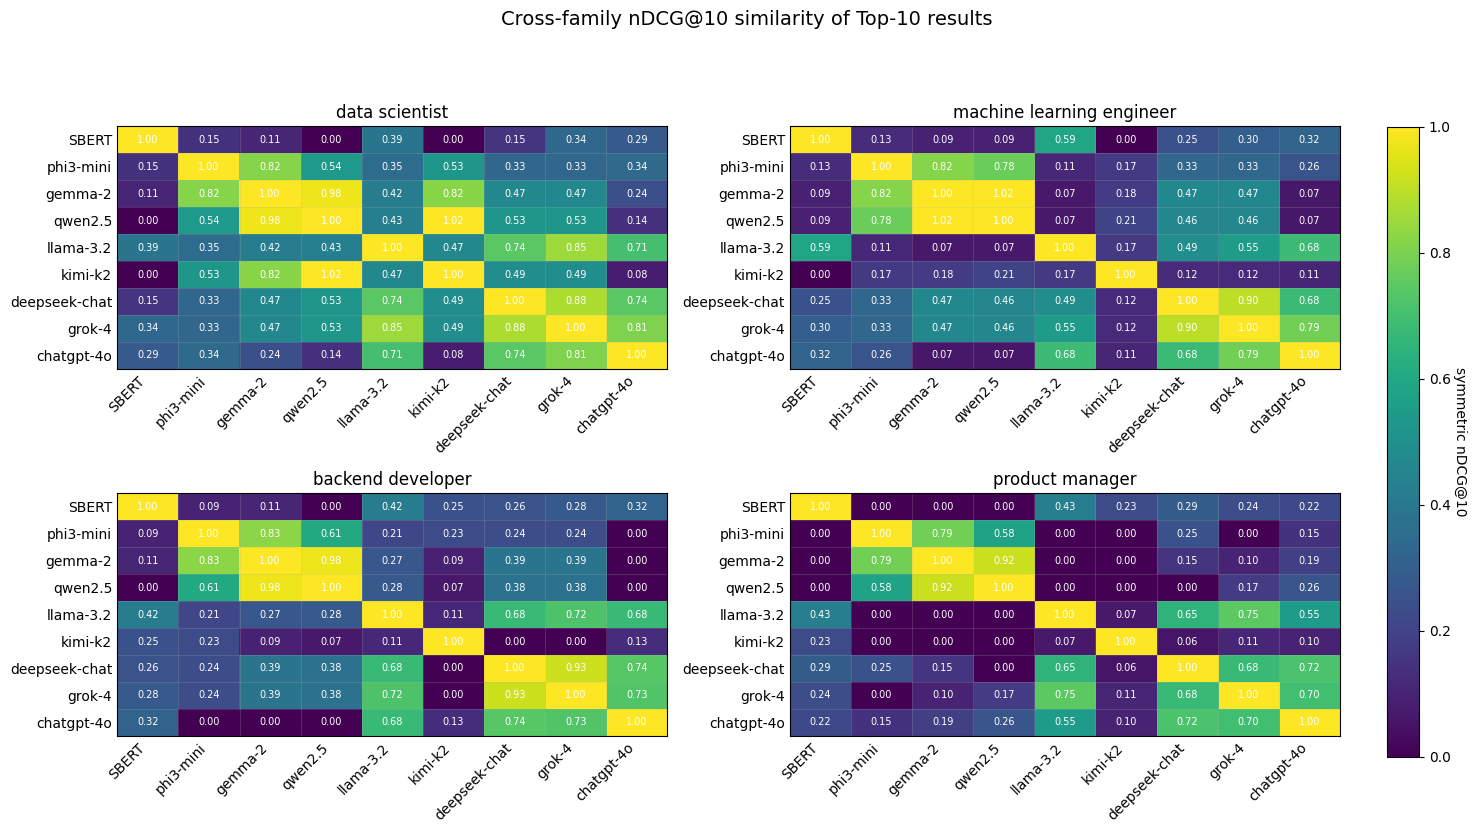

In [103]:
# PLOT
topk_by_model = build_topk_by_query(all_models, k=K)

# pick first 4 queries for the 2×2
selected = queries[:4]

# Single figure with 2×2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=False)
axes = axes.flatten()

last_im = None
for ax, q in zip(axes, selected):
    mat = compute_matrix_for_query(q, topk_by_model, DISPLAY_ORDER)
    im = ax.imshow(mat.values, vmin=0.0, vmax=1.0, interpolation="nearest", aspect="auto")
    last_im = im

    ax.set_xticks(range(len(mat.columns)))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(mat.index)))
    ax.set_yticklabels(mat.index)
    ax.set_title(q)

    ax.set_xticks(np.arange(-.5, len(mat.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(mat.index), 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.3)
    ax.tick_params(which="both", length=0)
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat.values[i, j]:.2f}",
                    ha="center", va="center", color="white", fontsize=7)

# hide any unused axes if <4 queries
for ax in axes[len(selected):]:
    ax.axis("off")

# lay out subplots and LEAVE room on the right
fig.suptitle("Cross-family nDCG@10 similarity of Top-10 results", fontsize=14, y=0.98)
fig.tight_layout(rect=[0.03, 0.06, 0.88, 0.93])  # <-- reserve right margin

# add a DEDICATED colorbar axis (x0, y0, width, height in figure coords)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])  # right-side, tall & thin
cbar = fig.colorbar(last_im, cax=cbar_ax)
cbar.ax.set_ylabel("symmetric nDCG@10", rotation=270, labelpad=12)


plt.show()


### Conclusion

The cross-family similarity matrices reveal that **smaller LLMs run locally** (Phi-3, Gemma-2, Qwen2.5, Llama-3.2) achieve **considerable agreement** in their top-10 rankings, especially under **listwise prompting**.  
In contrast, rankings derived from **SBERT embeddings with cosine similarity** diverge more strongly from LLM-based outputs.  
Meanwhile, **DeepSeek, Grok, and ChatGPT-4o** show **relevant alignment with each other**, reflecting their **pairwise prompt setup**.

👏🦙 Notably, **LLaMA-3**, even when prompted listwise, reaches a **similar agreement level to larger API-based LLMs**, highlighting its strong performance.  



---